In [1]:
import classes
import functies
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, join
functies.round_to_n(1.00,1)

test123


1.0

In [2]:
#puntje 2: definiëren van de functies
k, omega, p_0, p_0_x, phi, v, x, t = sp.symbols('k omega p_0 p_0_x phi v x t')

#max amplitude in functie van x 
drukamplitude_vergelijking = classes.vergelijking(p_0 * sp.sin(k*x + phi))
drukamplitude_parameters = ['k', 'p_0', 'phi', 'C']

def drukamplitude_model(X, parameters):
    K, P_0, PHI, C = parameters
    return P_0 * abs(np.sin(K*X + PHI) + C) #bij de x-fit steeds positief (anders breekt het omdat de vorige fit brakt)

#amplitude in functie van tijd voor vaste x 
druktijd_vergelijking = classes.vergelijking(p_0*sp.sin(omega*t+phi)) #merk op dat dit niet per sé dezelfde phi is als voor x, maar is irrelevant voor de fitcode
druktijd_parameters = ['omega', 'p_0_x', 'phi', 'C']

def druktijd_model(T, parameters):
    omega, P_0, phi, C = parameters
    return P_0*np.sin(omega*T+phi) + C

#snelheid als omega en k gekend zijn
snelheid_vergelijking = classes.vergelijking(omega/k *10**5) #de 10**5 is om de vage eenheden die nodig zijn om de fits te doen werken te fixen

In [3]:
###sjoemeliere sjoemelare om de txt files met de data om te zetten in effectieve nuttige dataverwerkingen
#blah blah...

###TEST_DATA:

X = np.array([0,100,200,300]) #een vector met de x-coordinaten van de metingen
T = np.array(
    [ np.linspace(1,15),
      np.linspace(0,10), #een matrix met de tijden voor elke meting op elke x-coordinaat
      np.linspace(1,11),
      np.linspace(7, 27)
])

P = np.array(
    [ 0*np.linspace(1,15) + np.random.normal(0,1),
     0.5*np.sin(np.linspace(0,10)+3)+np.random.normal(0,1), #een matrix met coordinaten P[x_coordinaat][tijd] #random normale fouten ingevoegd voor de test
          np.sin(np.linspace(0,10)+np.random.normal(0,1)), 
      0.5*np.sin(np.linspace(0,10)-1)+np.random.normal(0,1)
])
P_fout = np.full(np.shape(P), 1) #een matrix van dezelfde vorm als P met de fouten in



xval = 0

In [ ]:
###vind de drukamplitude voor een vaste x-coordinaat
def fit_vaste_x(X, T, P, P_fout, invals = None, detailed_logs = False):
    """
    @IN:
    matrices X, T P en P_fout als gedefinieerd in vorige opgave
    @OUT:
    een lijst met maximale amplitude, in de volgorde van de x-coordinaat waarin ze voorkomen, en de pulsatie in datapuntvorm
    """
    
    P_0_x = []
    omega_x = []
    for xval in range(len(X)):
        def invals_amplitude(x,y):
            if invals is None:
                return [1,0,0,0]
            else:
                return invals[xval]
        druk = P[xval]
        drukfout = P_fout[xval]
        tijd = T[xval]
        print('druk, fout, tijd:')
        print(np.shape(druk))
        print(np.shape(drukfout))
        print(np.shape(tijd))
        tijdfit = functies.fit(druktijd_parameters, druktijd_model, invals_amplitude, tijd, druk, drukfout, detailed_logs = detailed_logs)
        print('\n\n')
        print(tijdfit, 'tijdfit')
        omega_x.append(functies.vector_to_datapunt(tijdfit[0].copy(), omega))
        P_0_x.append(tijdfit[1].copy())

        #plot het boeltje om te testen
        fig, ax = plt.subplots(1,1, figsize = (30,10))
        ax.errorbar(tijd, druk, yerr = drukfout, label = 'gemeten', fmt = "o" ,zorder = 1)
        T_fit = np.linspace(0, max(tijd),30000)
        druk_fit = tijdfit[1][0]*np.sin(tijdfit[0][0]*T_fit+tijdfit[2][0]) + tijdfit[3][0]
        ax.plot(T_fit, druk_fit, label = 'model', zorder = 2)

        testing = np.full(np.shape(T_fit), np.max(druk)) #Mijn vader beweerde iets raar te zien in de data, dus ff checken
        testing_min = np.full(np.shape(T_fit), np.min(druk)) #tis fine denk ik
        ax.plot(T_fit, testing)
        ax.plot(T_fit, testing_min)

        ax.set_ylabel('$V_0$ [mV]')
        ax.set_xlabel('T (s)')
        ax.legend("druk in functie van tijd")
        ax.legend()
        plt.tight_layout()
        plt.show()


    OMEGA = functies.mu_sigma(omega_x, omega)

    
    return P_0_x, OMEGA

#fix de drukamplitude naar de x-coordinaat
def fit_naar_x(X, P_0_x, P_0_x_ERR, invals = None, detailed_logs = False):
    def invals_naarx(x,y):
        if invals is None:
            return [0,0,0,0]
        else:
            return invals
    fitwaardes = functies.fit(drukamplitude_parameters, drukamplitude_model, invals_naarx, X, P_0_x, P_0_x_ERR, detailed_logs= detailed_logs)
    K = functies.vector_to_datapunt(fitwaardes[0], k)
    P_0 = functies.vector_to_datapunt(fitwaardes[1], p_0)
    PHI = functies.vector_to_datapunt(fitwaardes[2], phi)
    c = fitwaardes[3]
    return K, P_0, PHI, c

#voor de experimenten met vaste frequentie:
def fix_data(X, T, P, P_fout, invals_vaste_x = None, detailed_logs = False, fit_x_vals = True):
    #fit voor elke mogelijke vaste x zodat je amplitude(x) vindt
    P_0_x_lijst, OMEGA = fit_vaste_x(X, T, P, P_fout, invals_vaste_x, detailed_logs = detailed_logs)
    P_0_x = [P_0_x_elem[0] for P_0_x_elem in P_0_x_lijst]
    P_0_x_ERR = [P_0_x_elem[1] for P_0_x_elem in P_0_x_lijst]
    print(P_0_x_ERR, 'P_0(x): de error')
    P_0_x = np.array(P_0_x)
    #fix dat er geen random tuples meer in uw error staan:
    for indx in range(len(P_0_x_ERR)):
        if type(P_0_x_ERR[indx]) == tuple:
            P_0_x_ERR[indx] = (P_0_x_ERR[indx][0] + P_0_x_ERR[indx][1])/2
    P_0_x_ERR = np.array(P_0_x_ERR)

    P_0_x = abs(P_0_x)

    #fit nu amplitude(x)
    #eerst als eens de punten plotten zodat we weten wat ermee aan te vangen indien het crasht
    fig, ax = plt.subplots(1,1, figsize = (30,10))
    ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')
    ax.set_ylabel('$V_0$ [mV]')
    ax.set_xlabel('x (m)')
    ax.legend("drukamplitude in functie van positie")
    ax.legend()
    plt.tight_layout()
    plt.show()
    #en nu voor echt fitten
    #beginwaardes bepalen
    minimum = min(P_0_x)
    maximum = max(P_0_x)
    if not invals_vaste_x is None:
        omega_gok = invals_vaste_x[0][0]
    else:
        omega_gok = OMEGA.get_val()
    Kgok = omega_gok*10**5/340
    phigok = np.arcsin(P_0_x[0]/(maximum - minimum)) - Kgok*X[0]
    invals = [Kgok, maximum-minimum, phigok, minimum]
    if fit_x_vals:
        print('initial values', invals)
        K, P_0, PHI, c= fit_naar_x(X, P_0_x, abs(P_0_x_ERR),invals, detailed_logs = detailed_logs)

        x_fit = np.linspace(0,max(X))
        druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*x_fit+PHI.get_val())) + c[0]
        #plot het boeltje
        fig, ax = plt.subplots(1,1, figsize = (30,10))
        ax.errorbar(X, P_0_x, yerr = P_0_x_ERR, label = 'gemeten', linestyle = ' ', marker = 'o')

        ax.plot(x_fit, druk_fit, label = 'model')

        ax.set_ylabel('$V_0$ [mV]')
        ax.set_xlabel('x (m)')
        ax.legend("drukamplitude in functie van positie")
        ax.legend()
        plt.tight_layout()
        plt.show()

        #bereken de snelheid
        snelheid = functies.data_analyse(snelheid_vergelijking, [OMEGA, K], v)
        print(snelheid)
        return [K, P_0, PHI, c, OMEGA]
    else:
        return [P_0_x, P_0_x_ERR, invals]


In [35]:
#### Hier volgt de effectieve data-analyse
#fix_data(X, T, P, P_fout, detailed_logs=False)

In [36]:
def X_tractor(inhoud): #extraheert effectief nuttige data uit die txt-files

    #@return: T in 10^-5 s (bro da werkt beter smh)

    #bepaal de initiële values van de fit (met de headerdata)
    amplitude = float(inhoud.split("PK-PK                :		")[1][:4])/2 #de helft van de peak-to-peak +20 om te kleine fits te breken
    freq = float(inhoud.split("Frequency            :		")[1][:4]) * 10**3 #het staat in kHz
    gesplit = inhoud.split('Time interval        :		')

    #bepaal de stapbreedte
    getal = ""
    eenheid = ""
    count = 0
    punt_gevonden = False
    for digit in gesplit[1]:
        if digit.isdigit():
            getal += digit
        elif digit == '.' and not punt_gevonden:
            getal += digit
            punt_gevonden = True
        else:
            eenheid+=digit
            count+=1
        if count == 2:
            break
    getal = float(getal)
    #fix de SI prefix van de stapbreedte
    if eenheid == "us": #bro een u voor µ deze oscilloscoop is ass
        stapbreedte = getal *10**(-1)# *10**(-6)
    elif eenheid == "ms":
        stapbreedte = getal * 10**2
    else:
        raise ChildProcessError("children have defined units of " + eenheid)
    #haal de twee kolommen uit de txt-file en transponeer ze
    tabel = gesplit[1].split('index		CH1_Voltage(mV)\n')[1]
    nuttigtransponent = [X.split('		') for X in tabel.split('\n')][:-1] #skip het laatste element want dat is leeg (een enter op het einde van de txt)
    nuttig = [[float(nuttigtransponent[j][i]) for j in range(len(nuttigtransponent))] for i in range(len(nuttigtransponent[0]))]
    #fix de verder gebruikte arrays in analyse
    T = np.array(nuttig[0])*stapbreedte
    T = T - T[0] #gezien het toch periodisch is kunnen we het laten starten bij nul
    Vpart = np.array(nuttig[1])        
    
    C = (np.max(Vpart)+np.min(Vpart))/2 #zou ook moeten werken i guess
    

    if Vpart[0] < Vpart[1]:
        phi = np.arcsin((Vpart[0] - C)/amplitude)
    else:
        phi = np.pi - np.arcsin((Vpart[0] - C)/amplitude)

    

    
    invals = [2*np.pi*freq*10**(-5), amplitude, phi, C] #Was eerder 4*pi*freq, maar omega=2pif, dus idk wat het plan was
    #Eenheden zijn enorm cooked, 10^-5 factor moet nog bij freq om shit te doen kloppen, zie twee code blokken verder, hier wat getest (werkte op oude code)
    return T, Vpart, eenheid, invals

In [37]:
#experiment 1: 1000 Hz, 35,3cm
mypath = "metingen laweit/1000Hz, 35.3cm"

def uncook_data(Tpart, Vpart, V_part_fout):
    Tnew = []
    Vnew = []
    Verrnew = []
    indx = 0
    while indx < len(Tpart)-1:
        indx2 = indx
        while indx2 < len(Tpart)-1 and Tpart[indx] == Tpart[indx2]:
            indx2 += 1
        
        tijd = np.mean(np.array([Tpart[ind] for ind in range(indx, indx2)]))
        spanning = Vpart[indx]
        fout = np.sqrt(indx2 - indx)*V_part_fout[indx]
        Tnew.append(tijd)
        Vnew.append(spanning)
        Verrnew.append(fout)
        indx = indx2
    Tnew = np.array(Tnew)
    Vnew = np.array(Vnew)
    Verrnew = np.array(Verrnew)
    assert np.shape(Verrnew) == np.shape(Vnew)
    return Tnew, Vnew, Verrnew

def get_data_from_folder(mypath):
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))] #met dank aan StackOverflow: een lijst met alle files in mypath
    afstanden = []
    T = []
    V = []
    invals = []
    Vfout = []
    #for i in range(5):
    COOKED = 0
    for filenaam in onlyfiles[1:]:# -------- Ik heb er ff voor gezorgd dat enkel de eerste 5 files gefit worden voor debugging purposes
        #                            ------- De eerste meting is een uitschieter dus skip die
        #filenaam = onlyfiles[i]
        nummer = float(filenaam[9:-4])*10**(-3)
        afstanden.append(nummer)
        bestand = open(mypath + '/' +filenaam,'rt')
        inhoud = bestand.read()
        bestand.close()
        Tpart, Vpart, eenheid, invals_vaste_x = X_tractor(inhoud)
        Vfout_part = np.full(np.shape(Vpart), 0.1)
        COOKEDbool = False
        for indx in range(len(Vpart)-2):
            if Vpart[indx] == Vpart[indx+1] == Vpart[indx+2]:
                print('FUCK YOU DE DATA IS COOKED')
                COOKEDbool = True

        if COOKEDbool:
            COOKED += 1
            Tpart, Vpart, Vfout_part = uncook_data(Tpart, Vpart, Vfout_part)
        V.append(Vpart[::2].copy()) #Dubbele sinusfunctie moet unzipped worden, dus om de index pakken als fix. Tis nogsteeds kapot, 
        #maar wss zullen amplitude en freq hetzelfde zijn, gwn andere +C
        T.append(Tpart[::2].copy())
        invals.append(invals_vaste_x.copy())
        Vfout.append(Vfout_part[::2].copy())
    print(COOKED)
    V = np.array(V)
    afstanden = np.array(afstanden)
    invals = np.array(invals)
    T = np.array(T)
    return [V, T, Vfout, afstanden, invals]


V, T, V_fout, afstanden, invals = get_data_from_folder(mypath)

FUCK YOU DE DATA IS COOKED
1


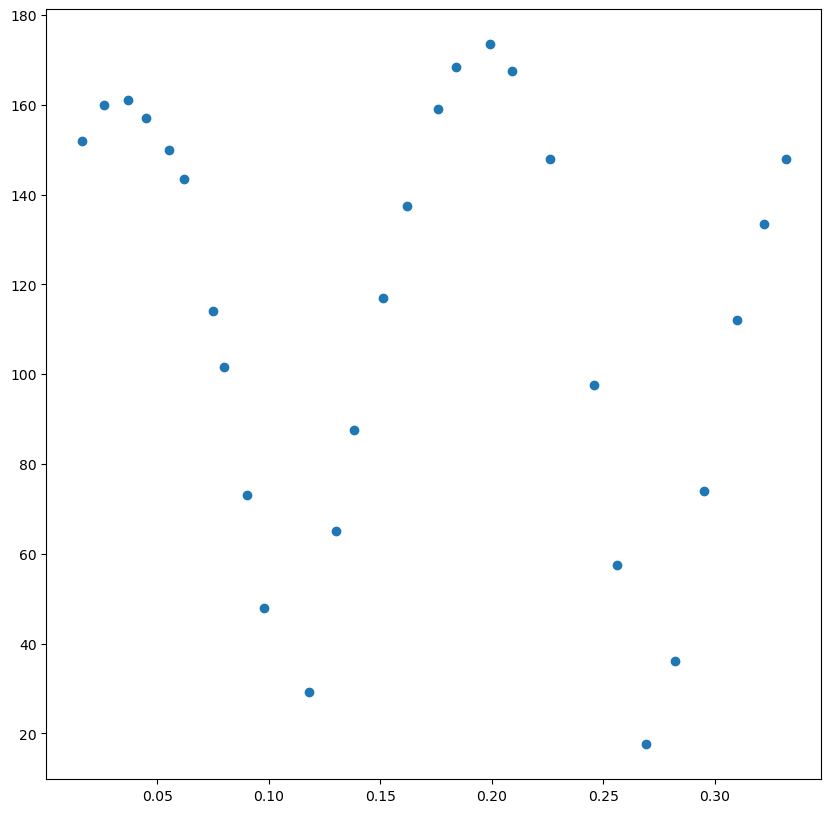

In [38]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.errorbar(afstanden, np.transpose(invals)[1], fmt='o')
plt.show()

druk, fout, tijd:
(5000,)
(5000,)
(5000,)
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 1314769.294410959
             x: [ 6.663e-02 -2.409e+01  6.290e+00  6.285e+00]
           nit: 325
          nfev: 543
 final_simplex: (array([[ 6.663e-02, -2.409e+01,  6.290e+00,  6.285e+00],
                       [ 6.663e-02, -2.409e+01,  6.290e+00,  6.285e+00],
                       ...,
                       [ 6.663e-02, -2.409e+01,  6.290e+00,  6.285e+00],
                       [ 6.663e-02, -2.409e+01,  6.290e+00,  6.285e+00]]), array([ 1.315e+06,  1.315e+06,  1.315e+06,  1.315e+06,
                        1.315e+06]))
[[0.06663281146827102, 0.10840534310900647], [-24.091952232220084, -24.083276409887045], [-339.2852593452529, -6559.638349720019], [6.282321350708159, 6.28845025024496]]
omega heeft als waarde: 0.066633 + 0.041772 - 1.5554e-07 met 68% betrouwbaarheidsinterval: [0.066633, 0.10841] 
p_0_x heeft als waard

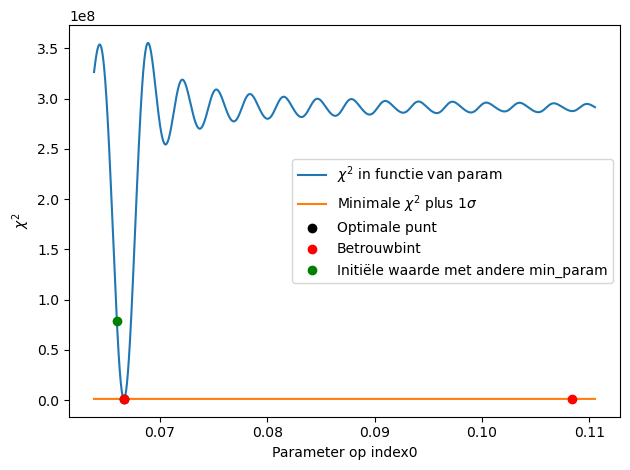

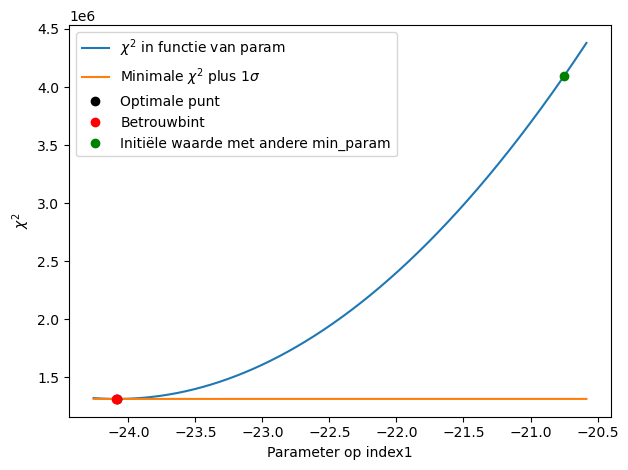

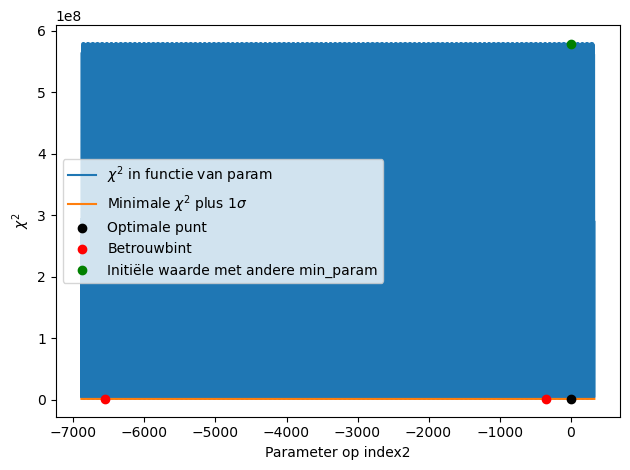

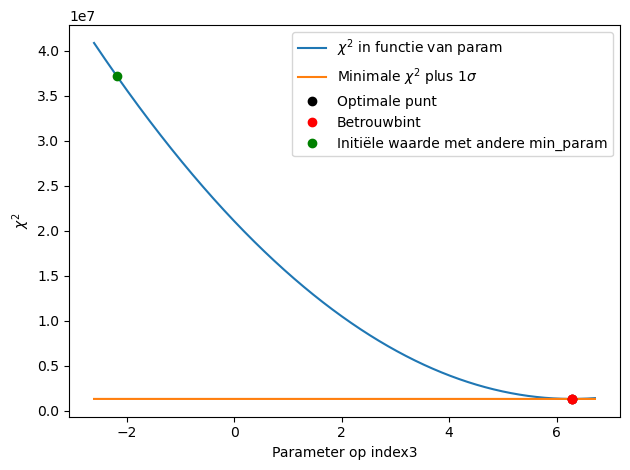

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 263.16
test123
test123
test123
test123
test123
test123



[[0.06663296700899987, (1.6e-07, 0.042), 'S'], [-24.087619051330783, 0.0043, 'S'], [6.290112560317324, (350.0, -6600.0), 'S'], [6.285388579767903, 0.0031, 'S']] tijdfit


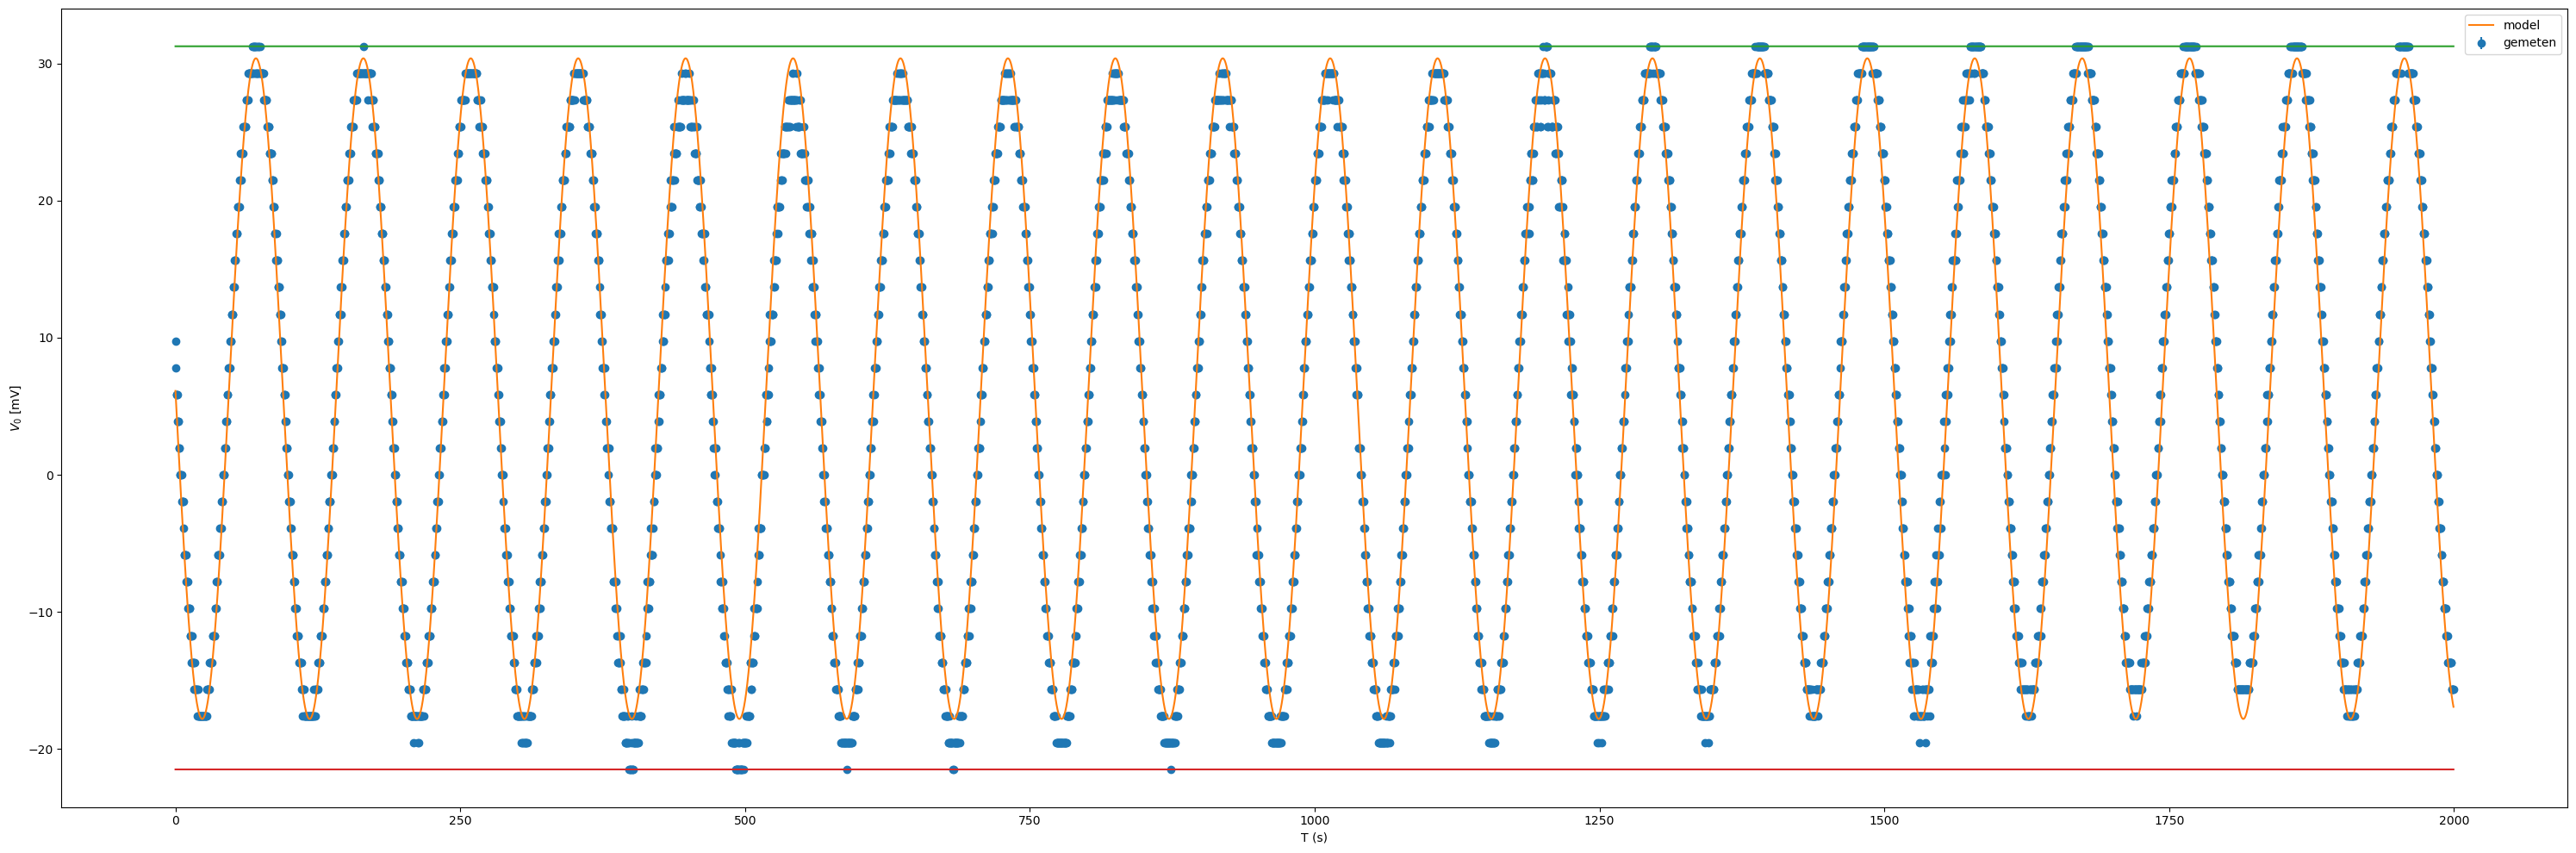

druk, fout, tijd:
(5000,)
(5000,)
(5000,)
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2267800.743543207
             x: [ 6.664e-02  6.074e+01  2.636e+00  6.945e+00]
           nit: 233
          nfev: 404
 final_simplex: (array([[ 6.664e-02,  6.074e+01,  2.636e+00,  6.945e+00],
                       [ 6.664e-02,  6.074e+01,  2.636e+00,  6.945e+00],
                       ...,
                       [ 6.664e-02,  6.074e+01,  2.636e+00,  6.945e+00],
                       [ 6.664e-02,  6.074e+01,  2.636e+00,  6.945e+00]]), array([ 2.268e+06,  2.268e+06,  2.268e+06,  2.268e+06,
                        2.268e+06]))
[[0.06664340340773596, 0.10842251831914368], [60.739010567578006, 60.74770851175003], [2.636365880998086, 2.636508077877087], [6.94214785454384, 6.948276751630375]]
omega heeft als waarde: 0.066643 + 0.041779 - 6.1458e-08 met 68% betrouwbaarheidsinterval: [0.066643, 0.10842] 
p_0_x heeft als waarde: 60

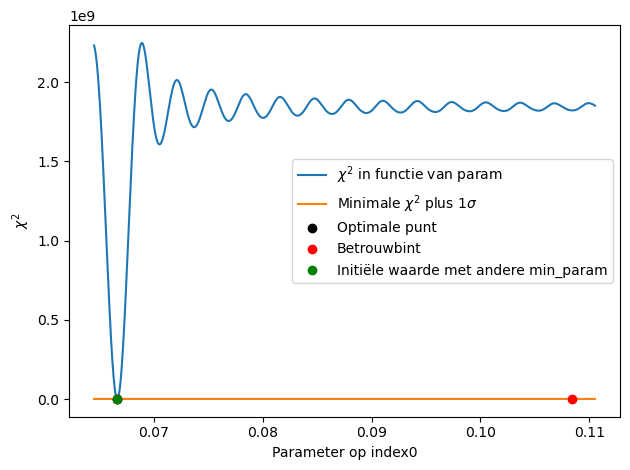

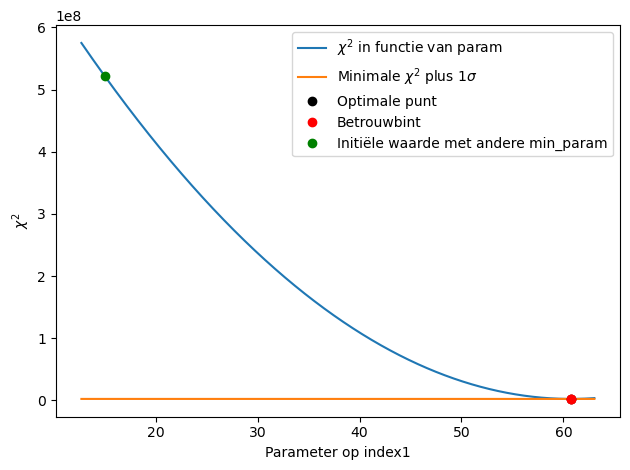

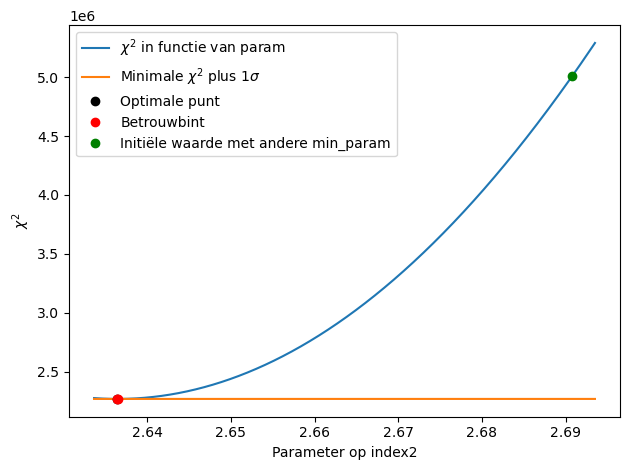

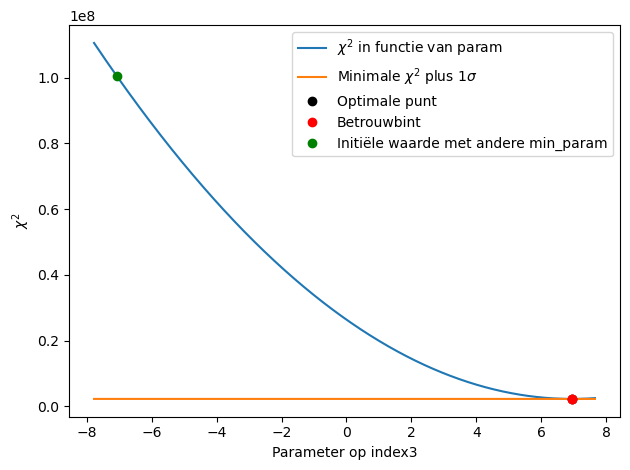

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 453.92
test123
test123
test123
test123
test123



[[0.06664346486572843, (6.1e-08, 0.042), 'S'], [60.743362594196086, 0.0044, 'S'], [2.636436924396093, 7.1e-05, 'S'], [6.94521201418595, 0.0031, 'S']] tijdfit


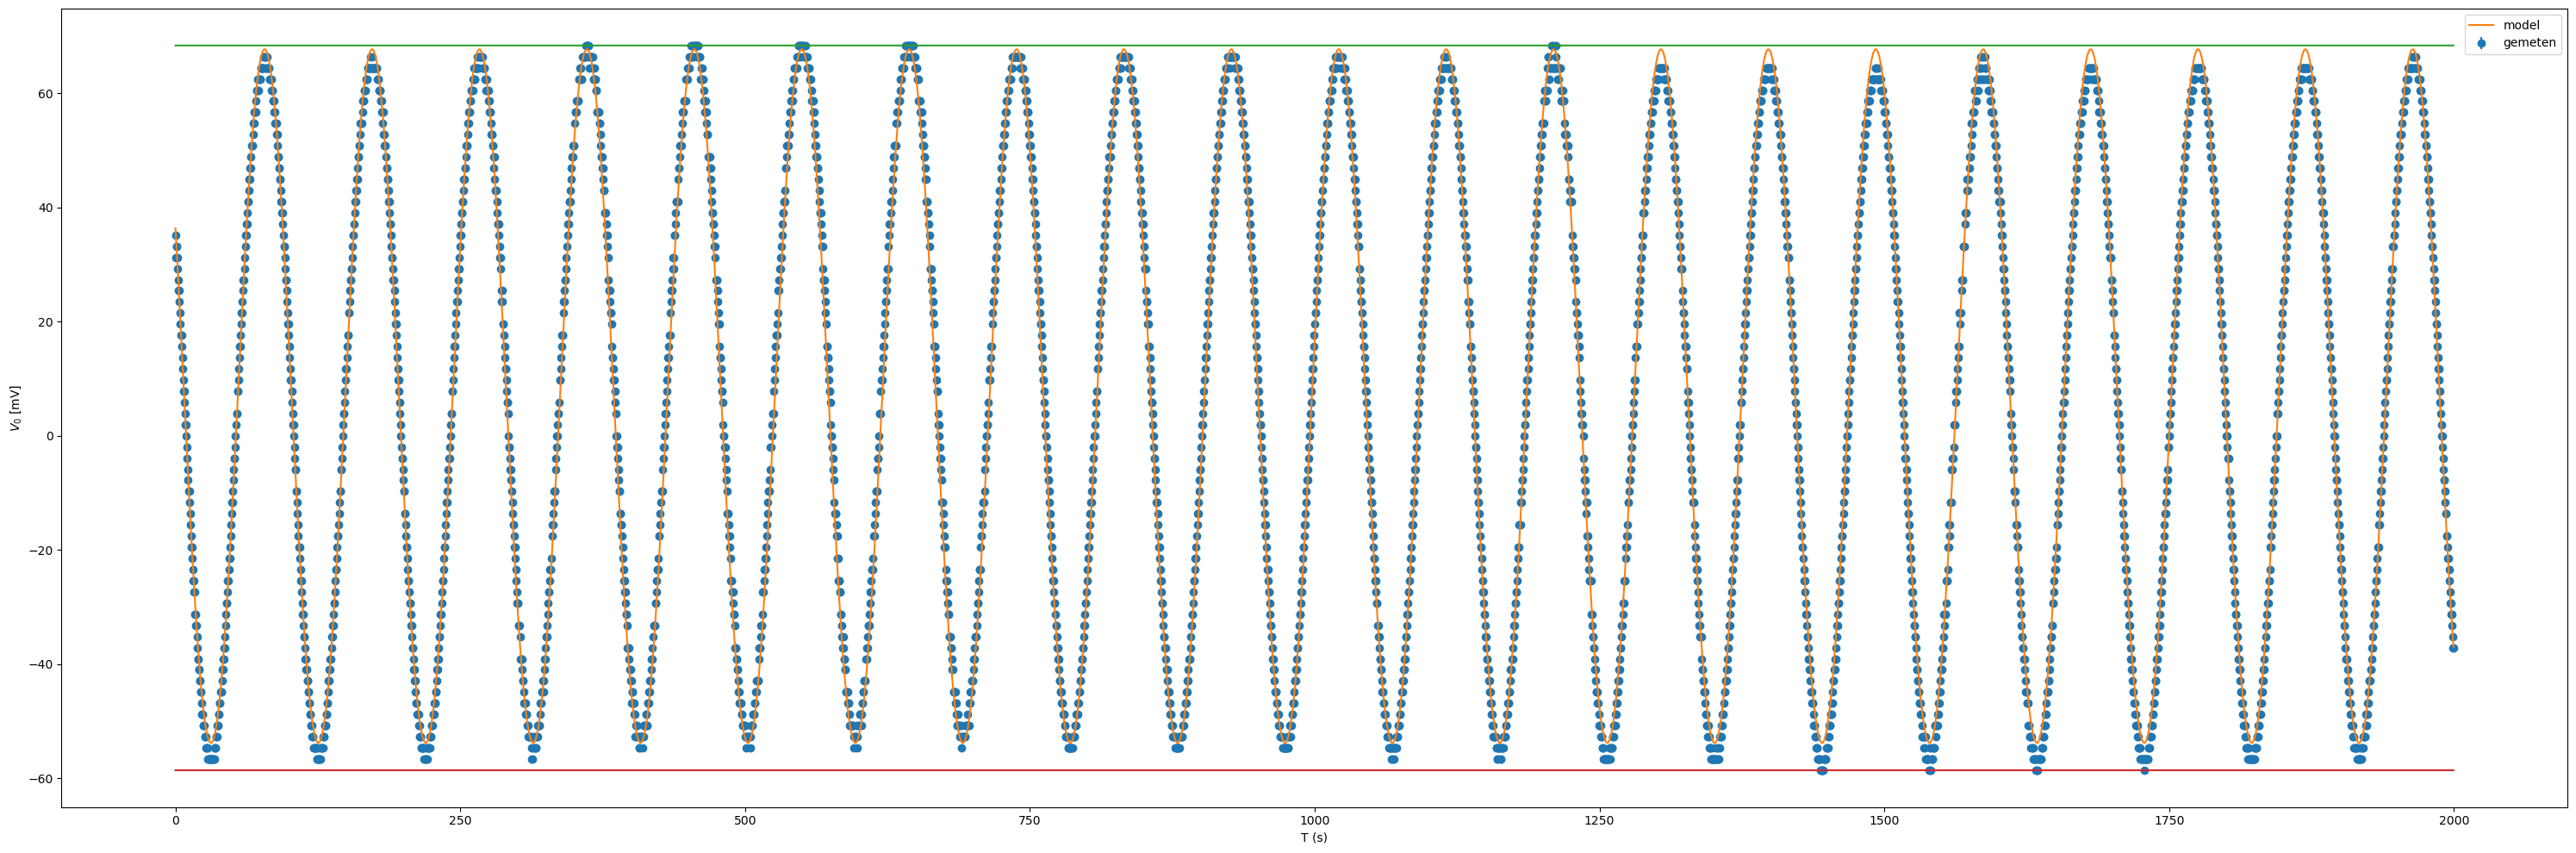

druk, fout, tijd:
(5000,)
(5000,)
(5000,)
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2774996.356448685
             x: [ 6.664e-02  8.281e+01  2.541e+00  5.925e+00]
           nit: 172
          nfev: 306
 final_simplex: (array([[ 6.664e-02,  8.281e+01,  2.541e+00,  5.925e+00],
                       [ 6.664e-02,  8.281e+01,  2.541e+00,  5.925e+00],
                       ...,
                       [ 6.664e-02,  8.281e+01,  2.541e+00,  5.925e+00],
                       [ 6.664e-02,  8.281e+01,  2.541e+00,  5.925e+00]]), array([ 2.775e+06,  2.775e+06,  2.775e+06,  2.775e+06,
                        2.775e+06]))
[[0.00043950351020519813, 0.10847312780335283], [82.80680651235332, 82.81550571259608], [2.541333324014278, 2.54143761299094], [5.921886085822895, 5.92801499693132]]
omega heeft als waarde: 0.066644 + 0.041829 - 0.066204 met 68% betrouwbaarheidsinterval: [0.0004395, 0.10847] 
p_0_x heeft als waarde: 82

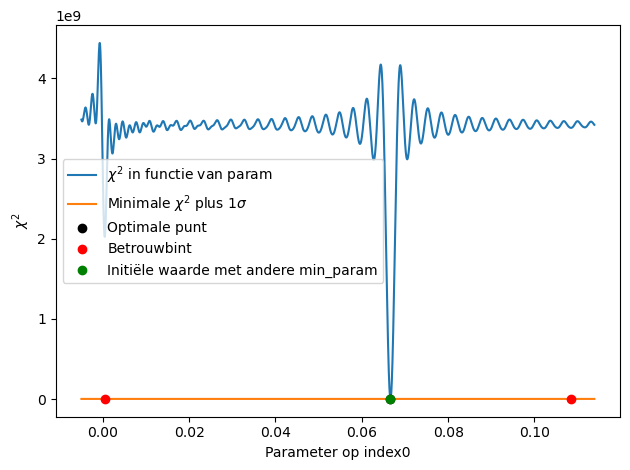

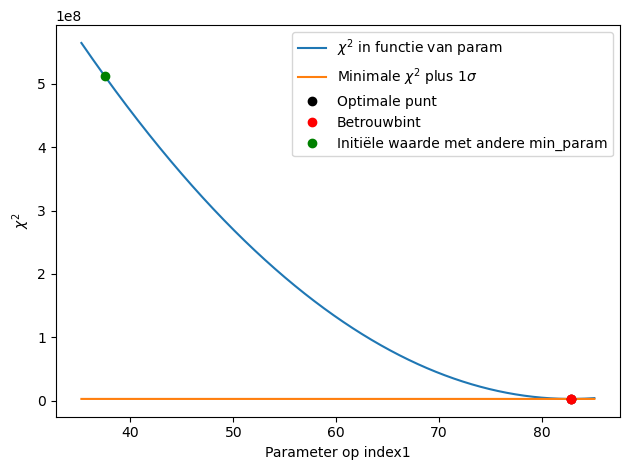

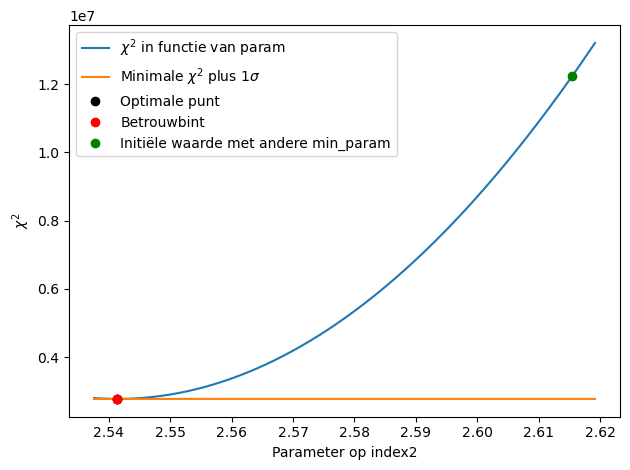

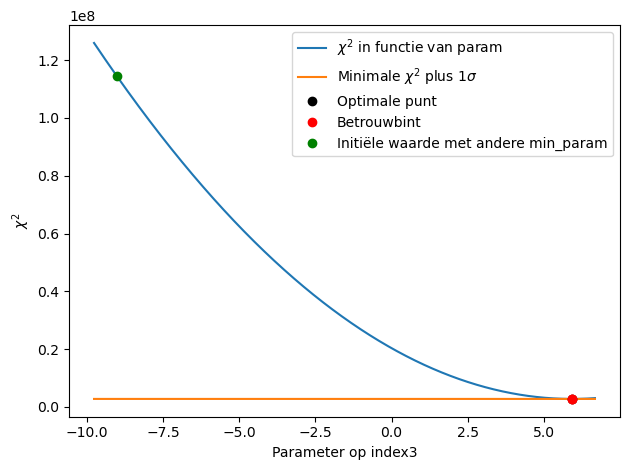

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 555.44
test123
test123
test123
test123
test123



[[0.06664363078214448, (0.066, 0.042), 'S'], [82.81115517115569, 0.0044, 'S'], [2.541385401385956, 5.2e-05, 'S'], [5.924943968632526, 0.0031, 'S']] tijdfit


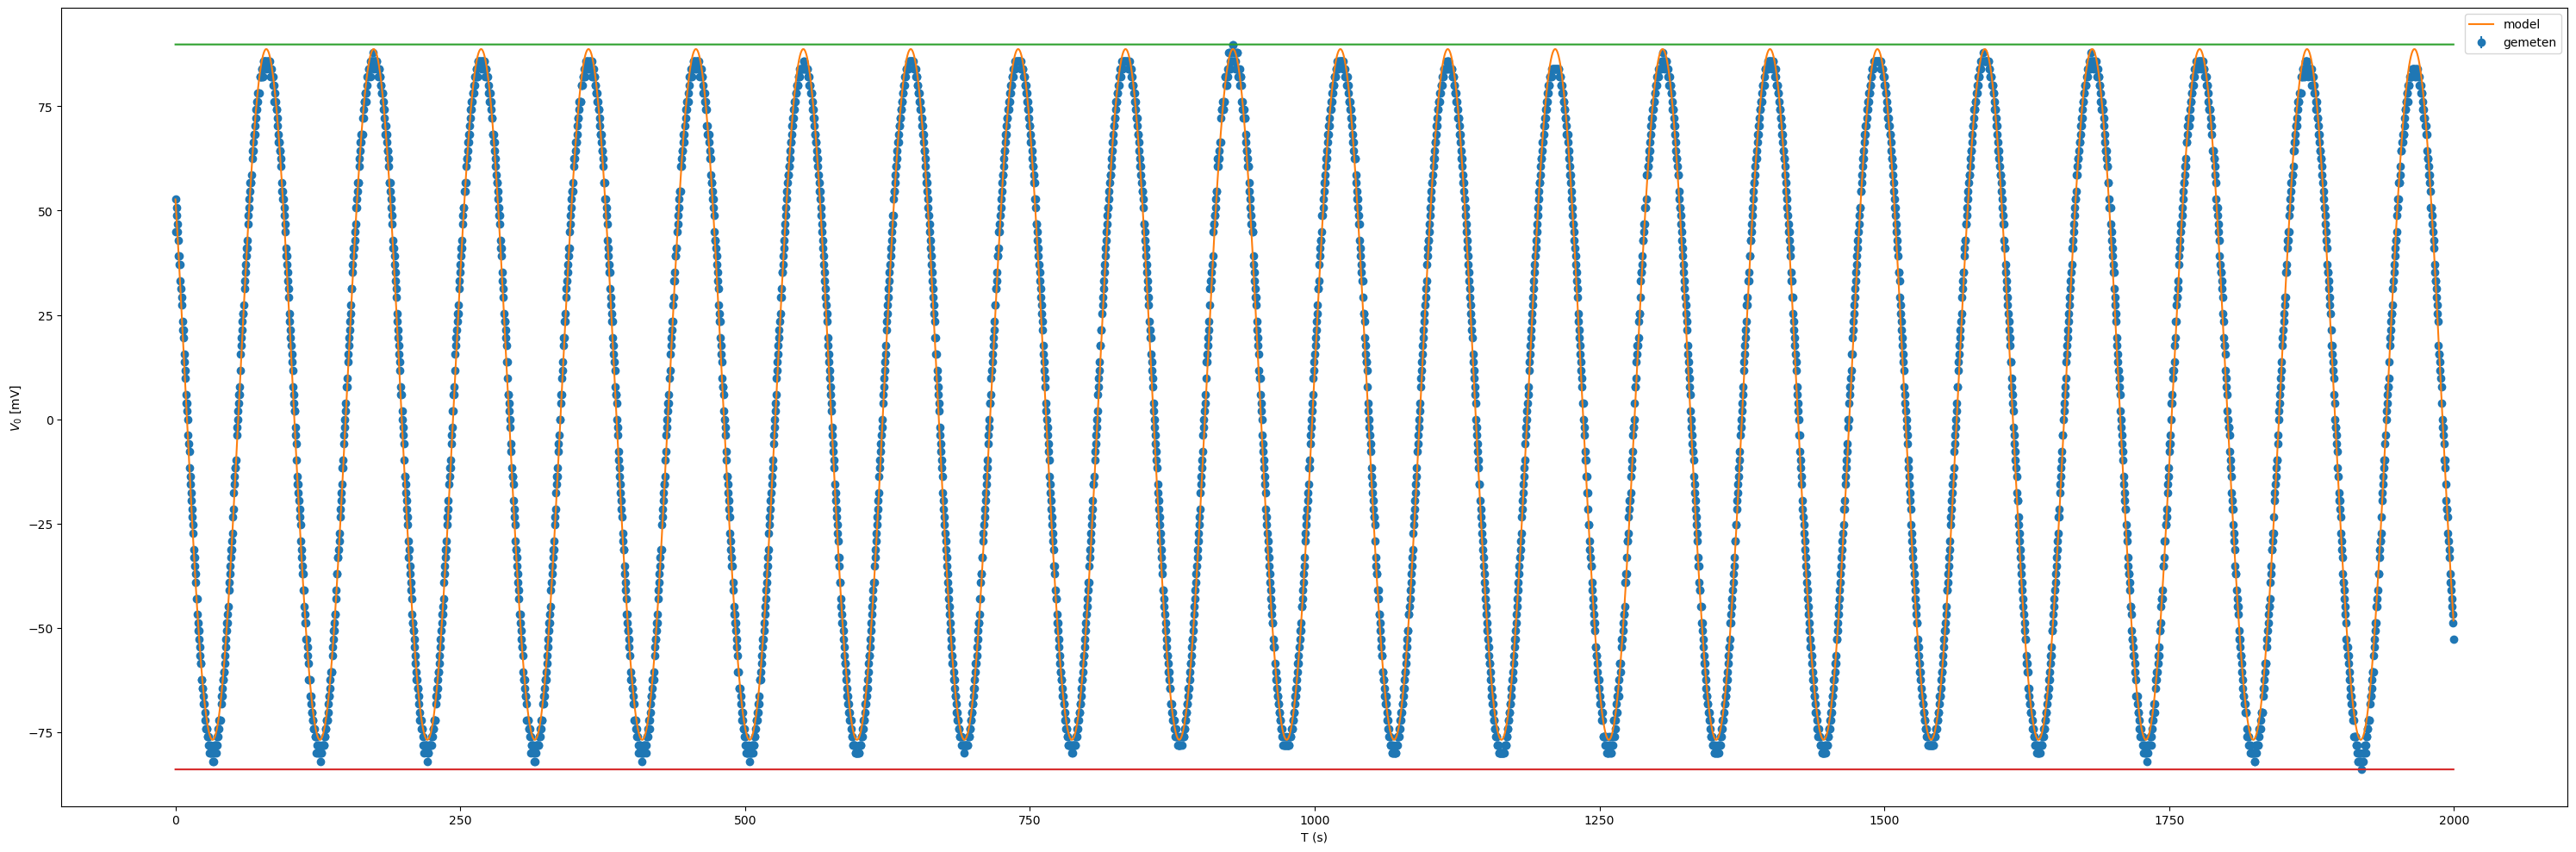

druk, fout, tijd:
(5000,)
(5000,)
(5000,)
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 6864847.228505228
             x: [ 6.665e-02  1.125e+02  2.530e+00  1.194e+00]
           nit: 159
          nfev: 276
 final_simplex: (array([[ 6.665e-02,  1.125e+02,  2.530e+00,  1.194e+00],
                       [ 6.665e-02,  1.125e+02,  2.530e+00,  1.194e+00],
                       ...,
                       [ 6.665e-02,  1.125e+02,  2.530e+00,  1.194e+00],
                       [ 6.665e-02,  1.125e+02,  2.530e+00,  1.194e+00]]), array([ 6.865e+06,  6.865e+06,  6.865e+06,  6.865e+06,
                        6.865e+06]))
[[0.011775842501752752, 0.06664964315695117], [112.50478519726894, 112.51348468061363], [2.5304105837856157, 2.5304873439864073], [1.1905817489013892, 1.1967106570615016]]
omega heeft als waarde: 0.06665 + 3.308e-08 - 0.054874 met 68% betrouwbaarheidsinterval: [0.011776, 0.06665] 
p_0_x heeft als waard

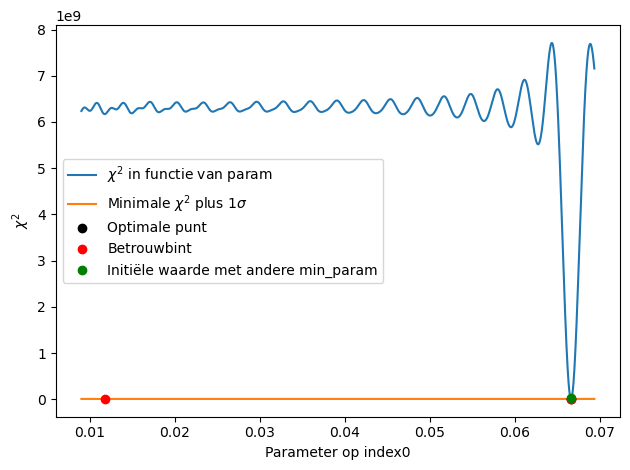

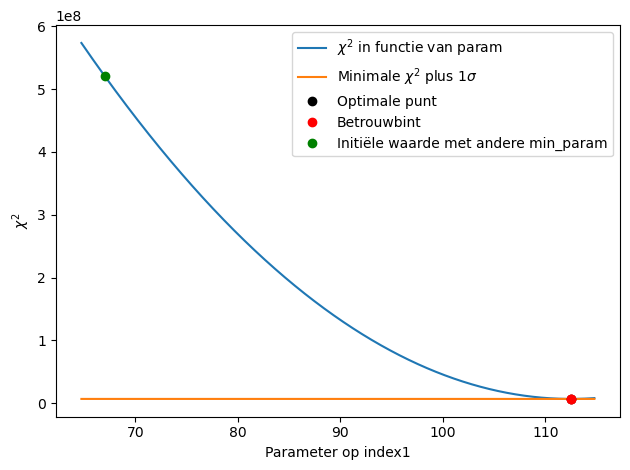

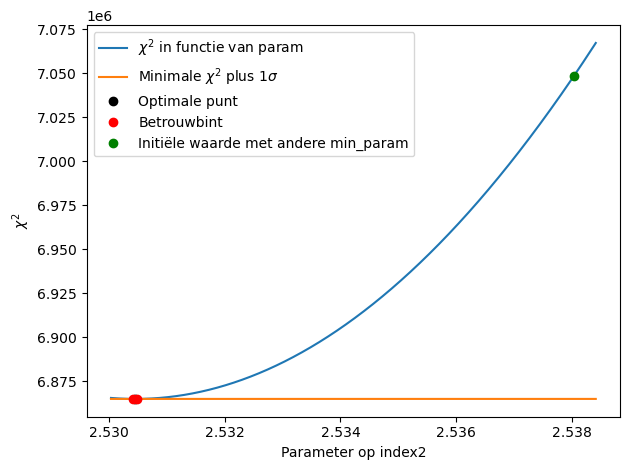

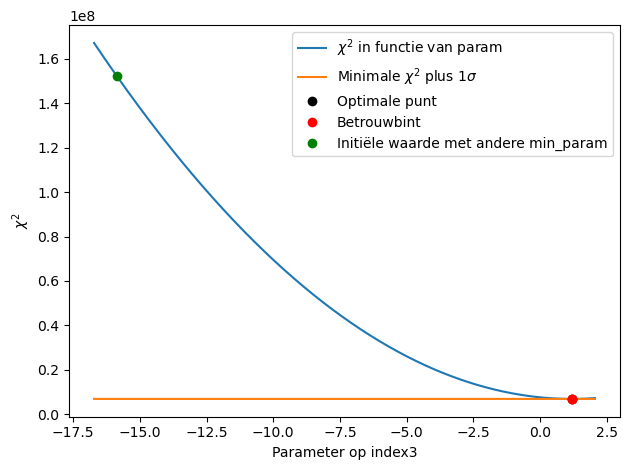

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 1374.1
test123
test123
test123
test123
test123



[[0.06664961007742189, (0.055, 3.3e-08), 'S'], [112.50910797313631, 0.0044, 'S'], [2.530449091404569, 3.9e-05, 'S'], [1.1936403569135488, 0.0031, 'S']] tijdfit


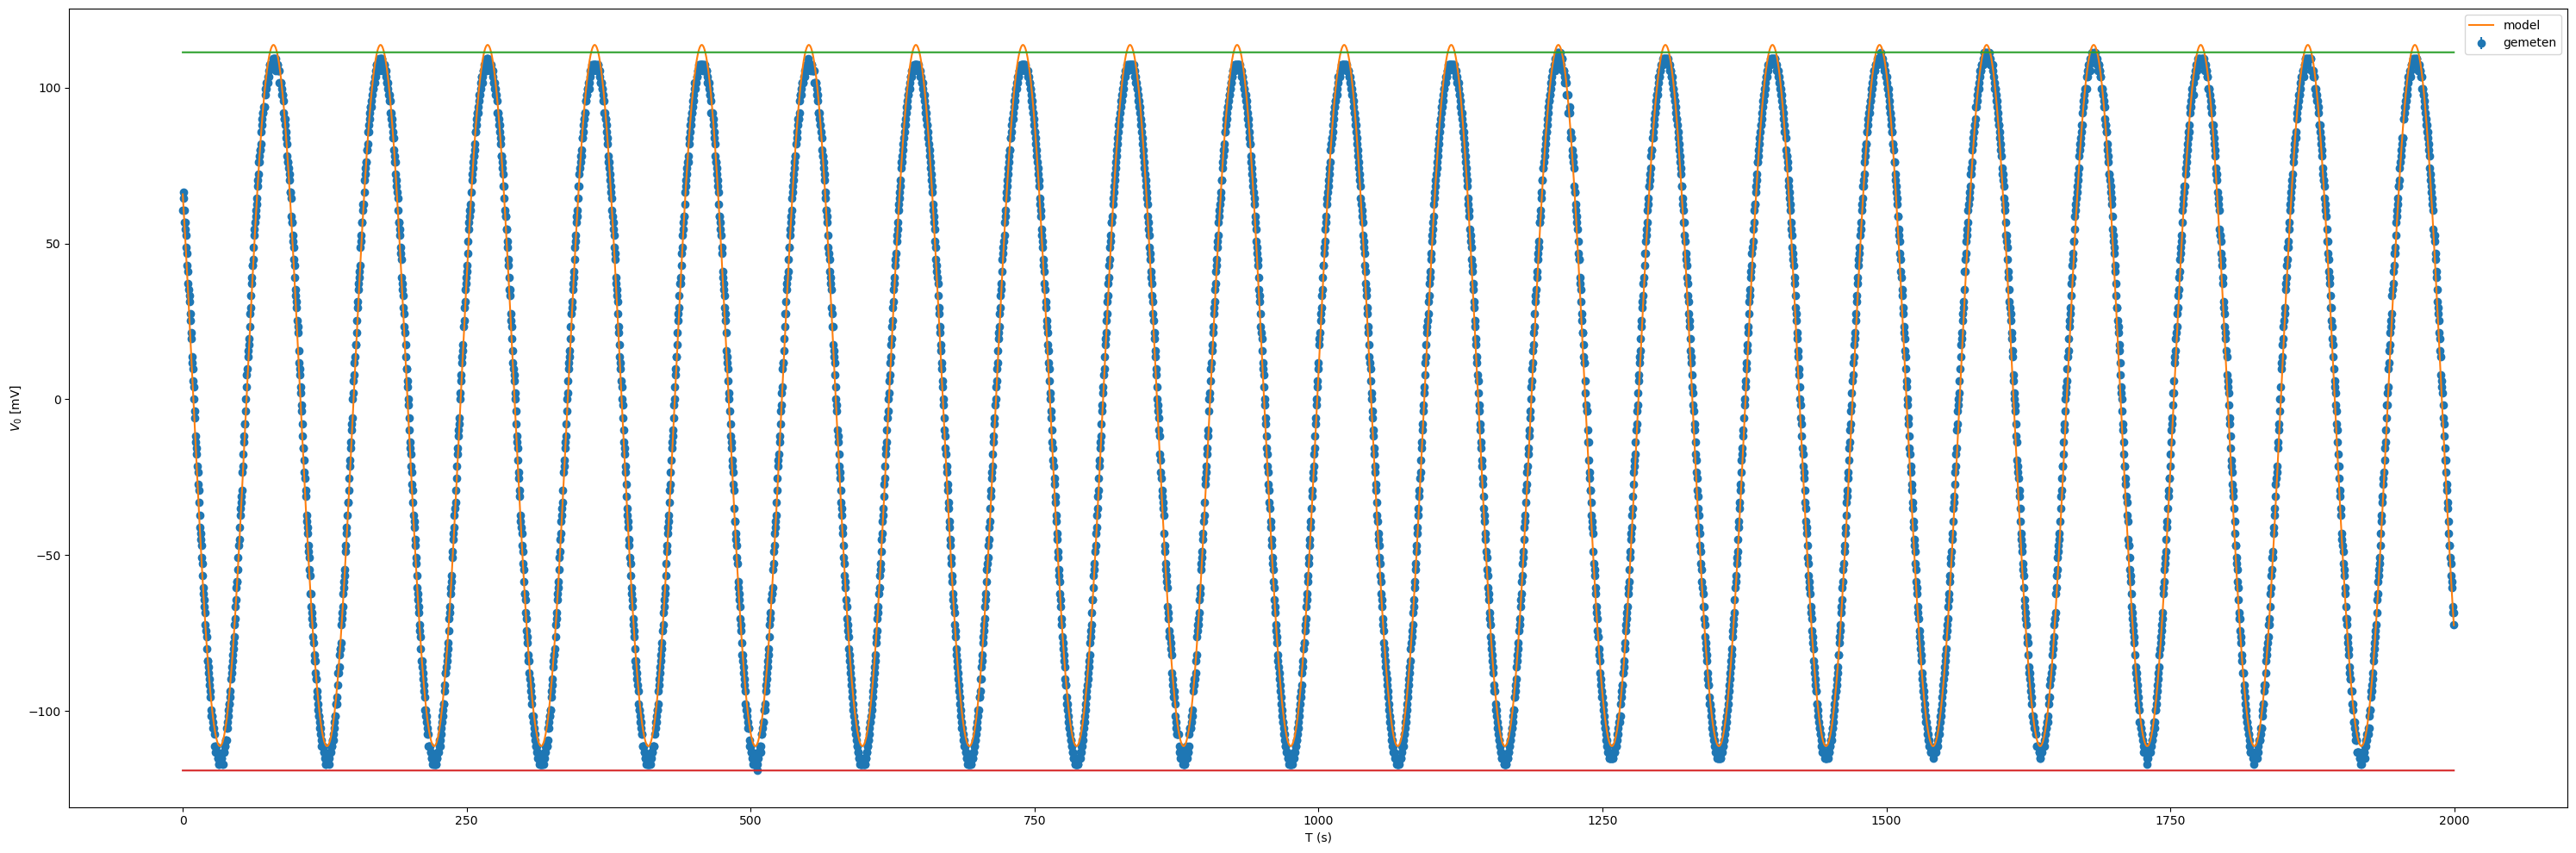

druk, fout, tijd:
(5000,)
(5000,)
(5000,)
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 13831238.441355297
             x: [ 6.664e-02  1.463e+02  2.480e+00  1.654e-01]
           nit: 180
          nfev: 313
 final_simplex: (array([[ 6.664e-02,  1.463e+02,  2.480e+00,  1.654e-01],
                       [ 6.664e-02,  1.463e+02,  2.480e+00,  1.654e-01],
                       ...,
                       [ 6.664e-02,  1.463e+02,  2.480e+00,  1.654e-01],
                       [ 6.664e-02,  1.463e+02,  2.480e+00,  1.654e-01]]), array([ 1.383e+07,  1.383e+07,  1.383e+07,  1.383e+07,
                        1.383e+07]))
[[0.011808164029834388, 0.06663854263568394], [146.29794507849522, 146.30664440143266], [2.479834182063834, 2.4798932116825023], [0.16231291813896895, 0.16844185009433624]]
omega heeft als waarde: 0.066639 + 2.5575e-08 - 0.05483 met 68% betrouwbaarheidsinterval: [0.011808, 0.066639] 
p_0_x heeft als w

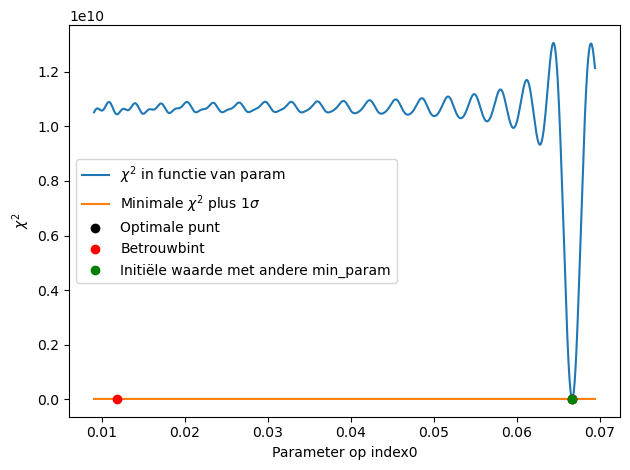

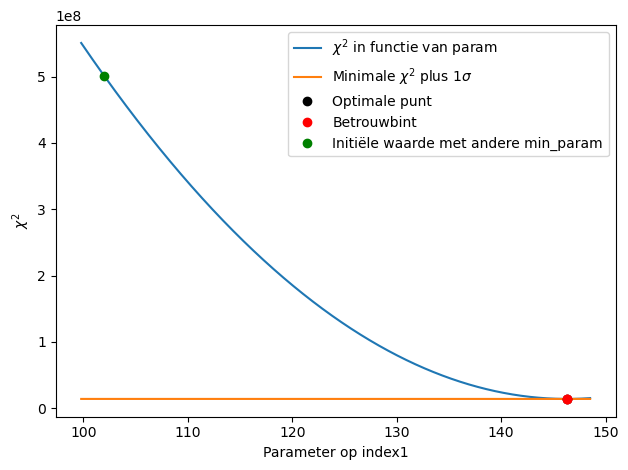

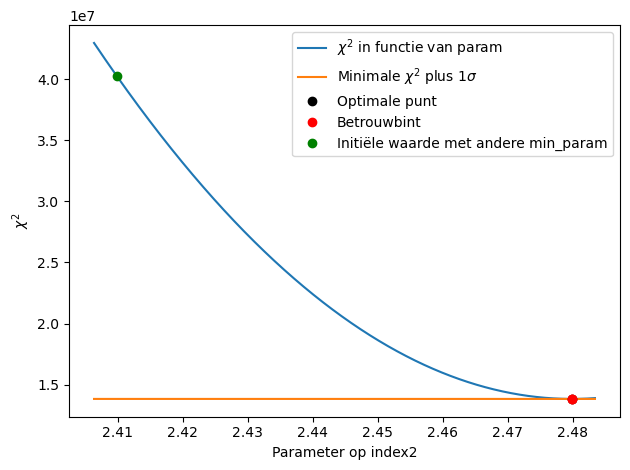

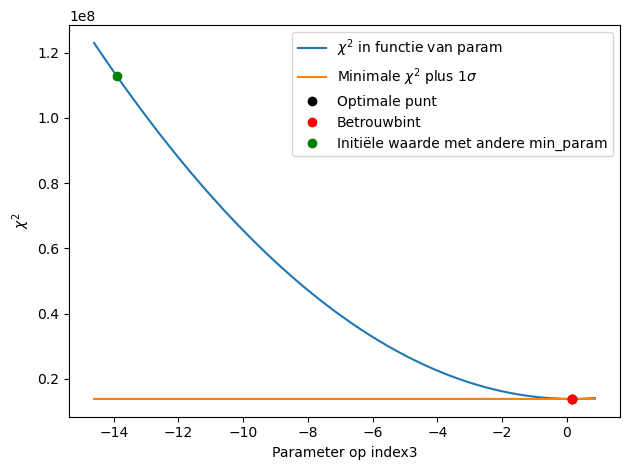

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 2768.5
test123
test123
test123
test123
test123



[[0.0666385170602935, (0.055, 2.6e-08), 'S'], [146.30229807239482, 0.0044, 'S'], [2.4798636641555953, 3e-05, 'S'], [0.16538773023704836, 0.0031, 'S']] tijdfit


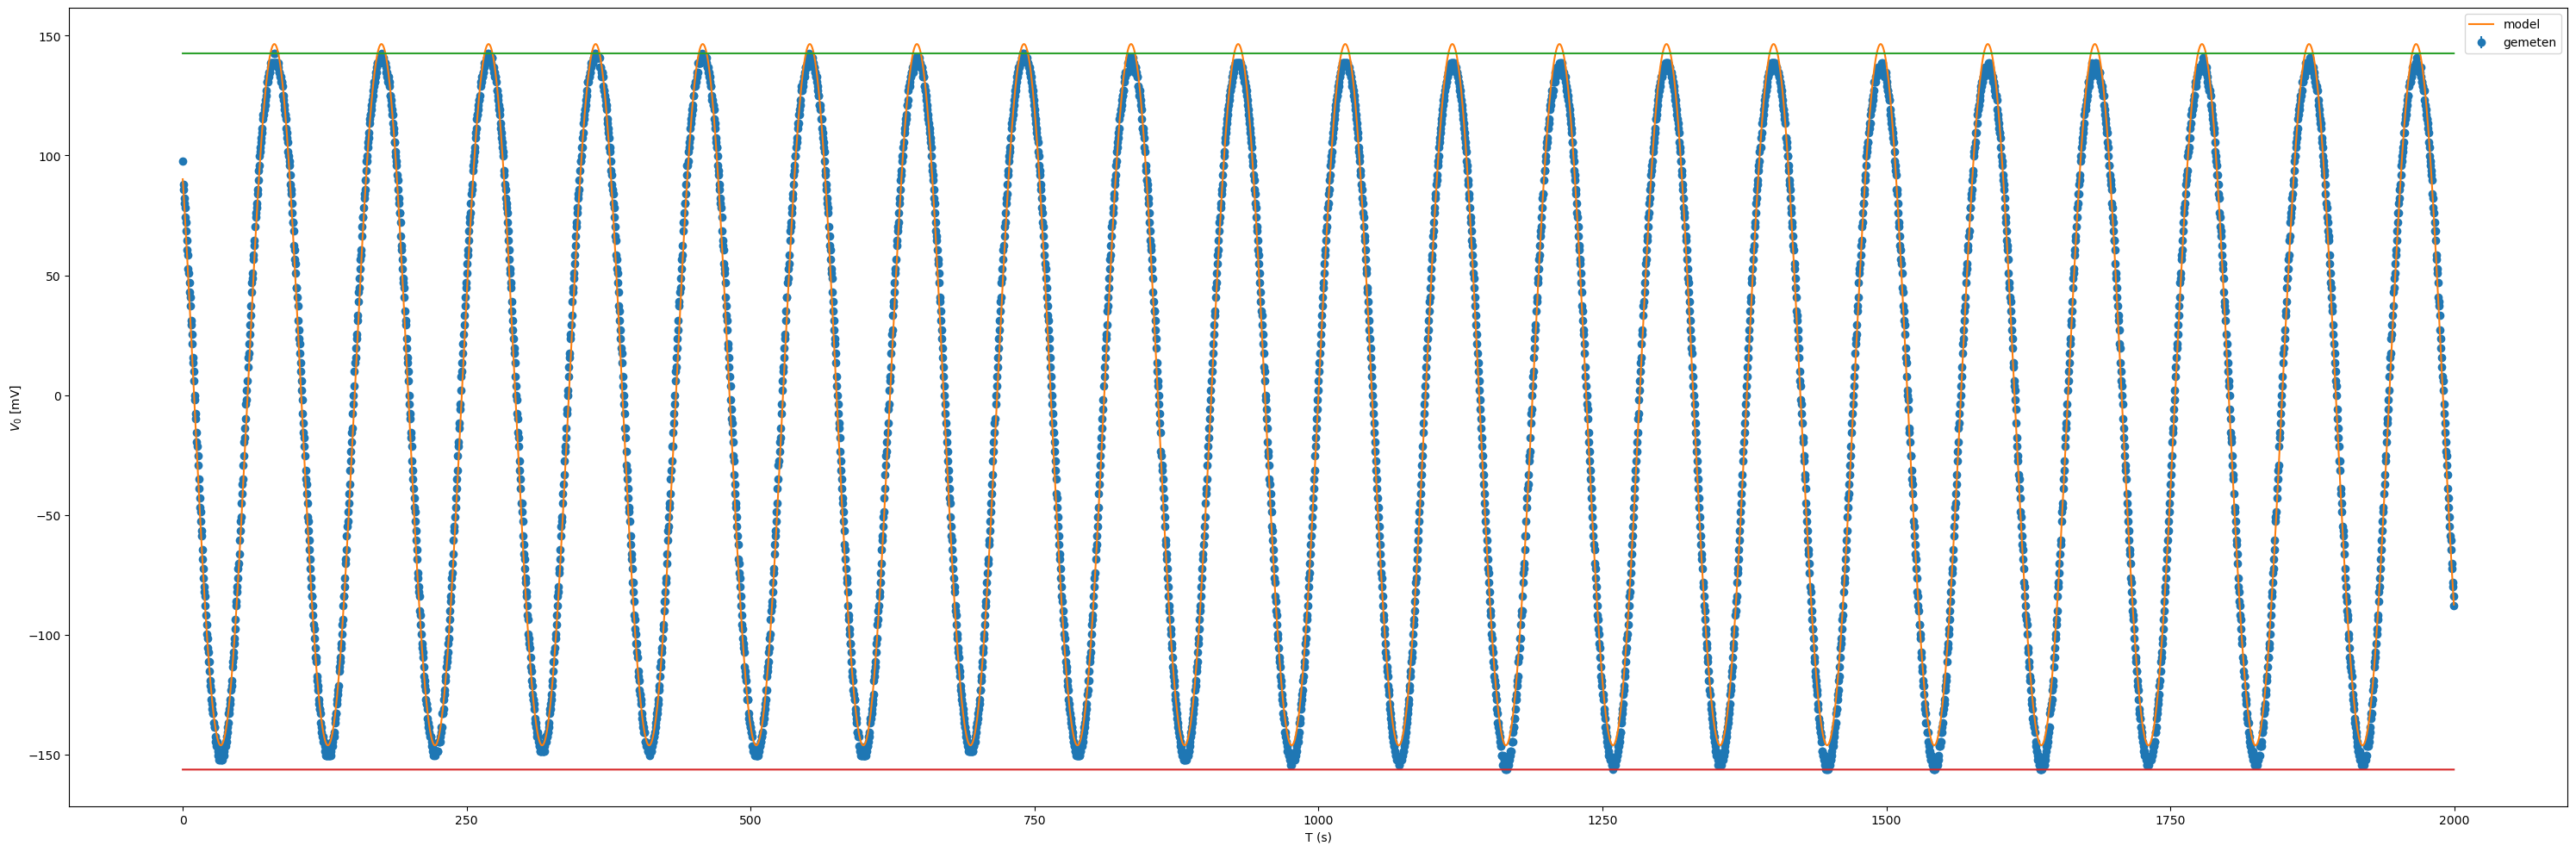

druk, fout, tijd:
(5000,)
(5000,)
(5000,)
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 12287263.434862942
             x: [ 6.665e-02  1.328e+02  2.476e+00  1.530e+00]
           nit: 171
          nfev: 313
 final_simplex: (array([[ 6.665e-02,  1.328e+02,  2.476e+00,  1.530e+00],
                       [ 6.665e-02,  1.328e+02,  2.476e+00,  1.530e+00],
                       ...,
                       [ 6.665e-02,  1.328e+02,  2.476e+00,  1.530e+00],
                       [ 6.665e-02,  1.328e+02,  2.476e+00,  1.530e+00]]), array([ 1.229e+07,  1.229e+07,  1.229e+07,  1.229e+07,
                        1.229e+07]))
[[0.0005280264233684428, 0.10854682359600892], [132.78449246387282, 132.79319198796327], [2.4760309131315426, 2.476095948482515], [1.52654040858457, 1.5326693058025396]]
omega heeft als waarde: 0.066652 + 0.041895 - 0.066124 met 68% betrouwbaarheidsinterval: [0.00052803, 0.10855] 
p_0_x heeft als waar

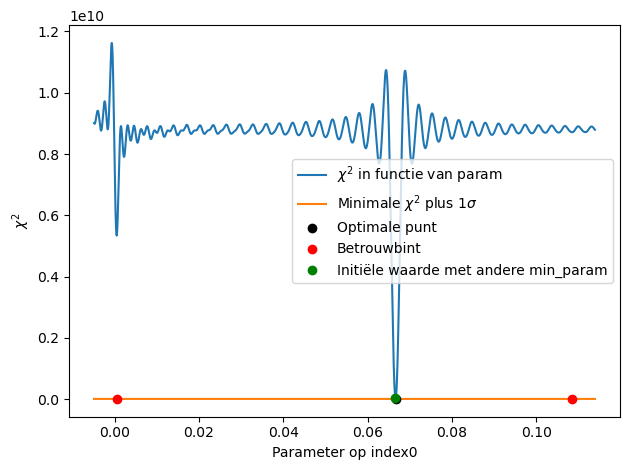

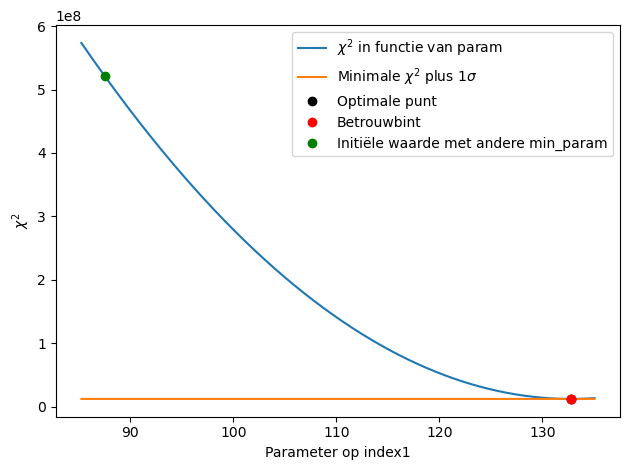

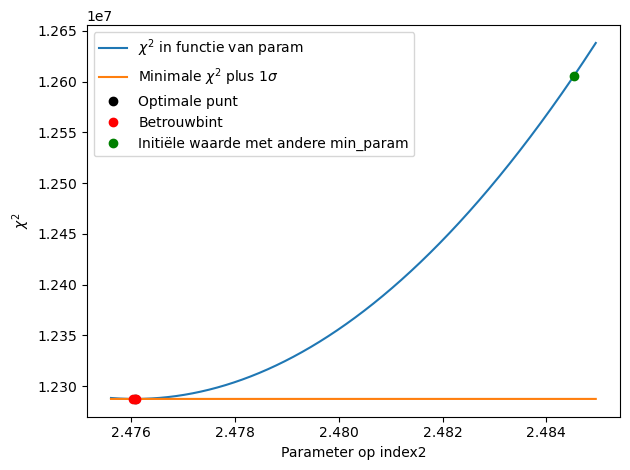

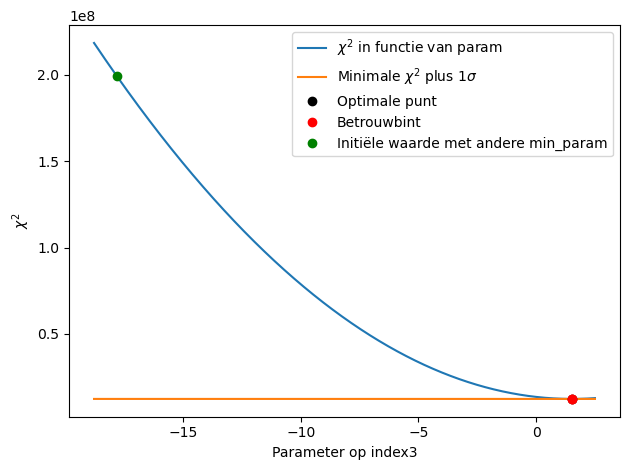

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 2459.4
test123
test123
test123
test123
test123



[[0.06665192684564857, (0.066, 0.042), 'S'], [132.78884583395038, 0.0044, 'S'], [2.4760634286195997, 3.3e-05, 'S'], [1.5296040714294188, 0.0031, 'S']] tijdfit


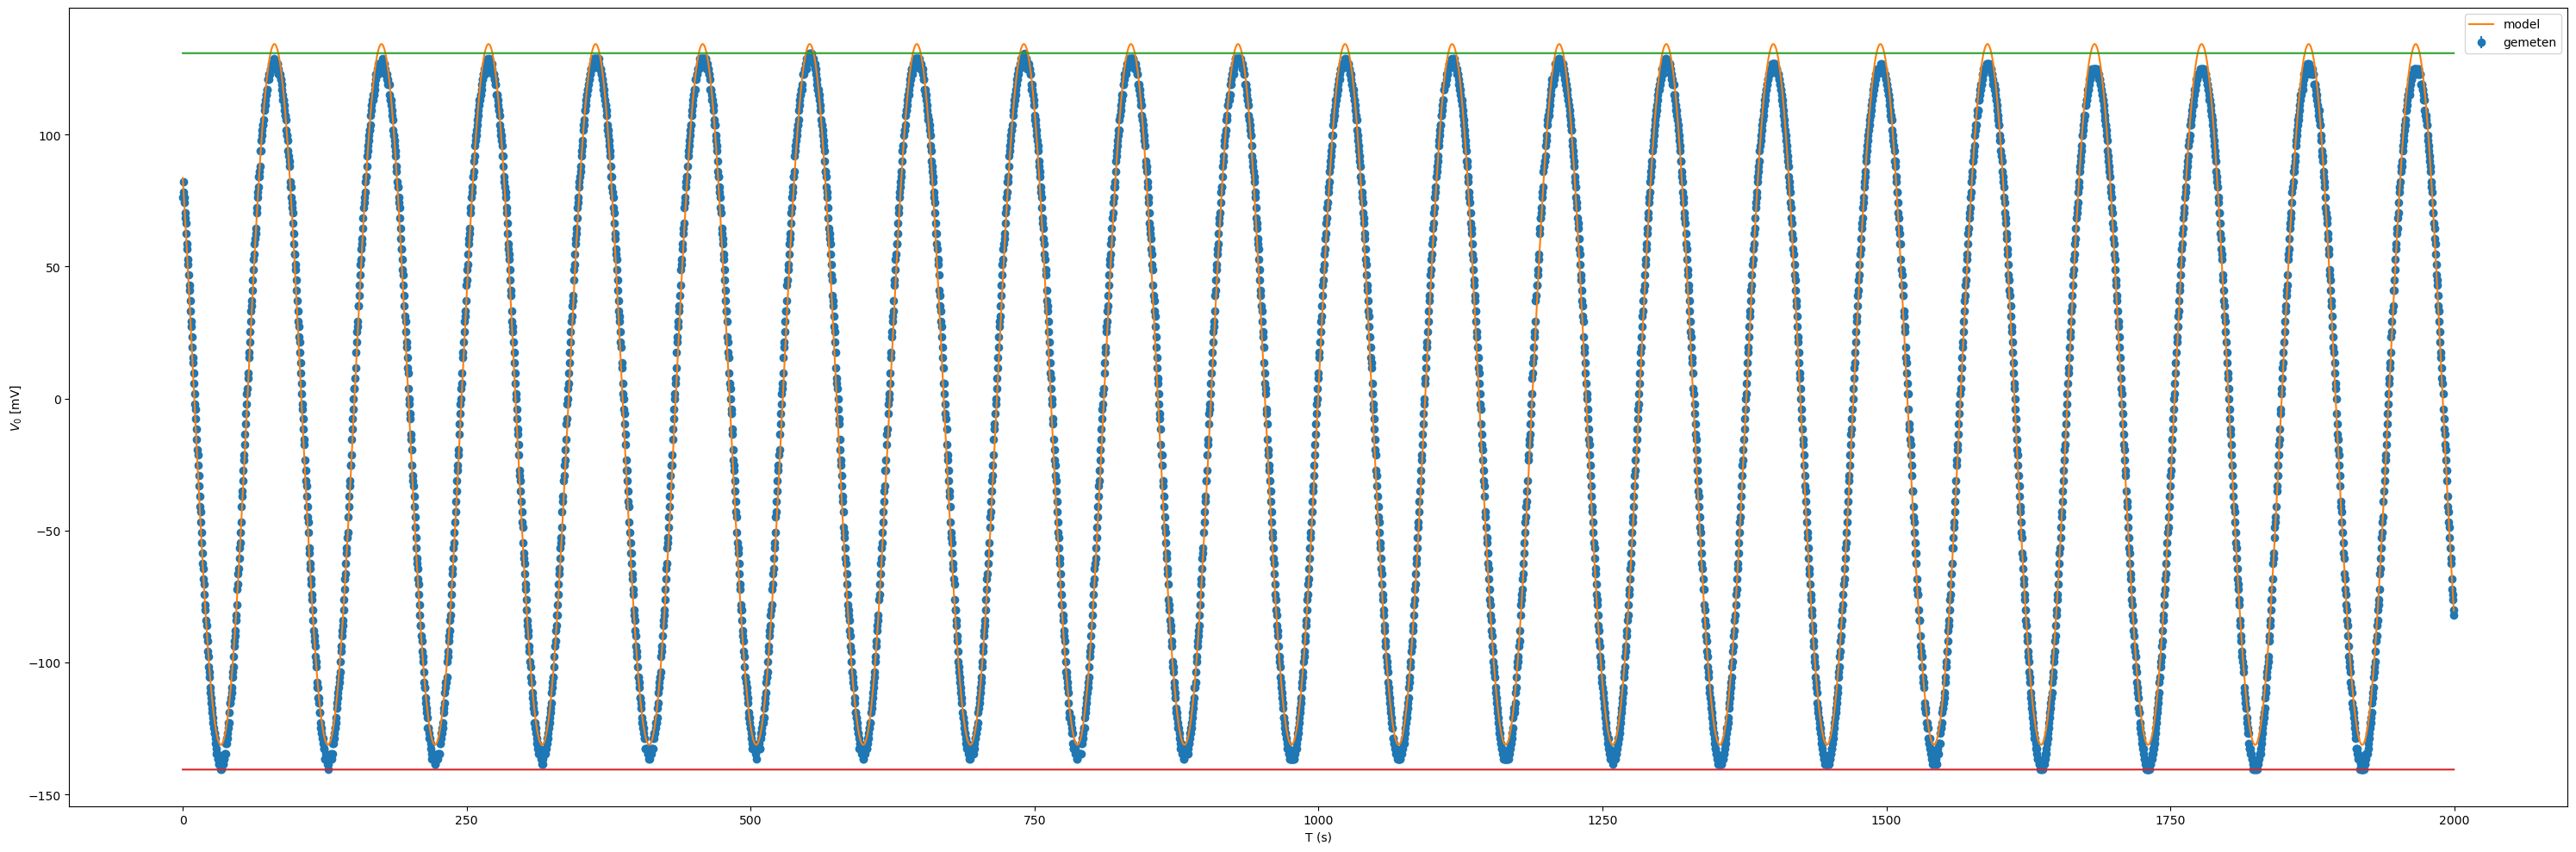

druk, fout, tijd:
(5000,)
(5000,)
(5000,)
Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 15043303.93115719
             x: [ 6.666e-02  1.533e+02  2.447e+00 -6.339e+00]
           nit: 153
          nfev: 276
 final_simplex: (array([[ 6.666e-02,  1.533e+02,  2.447e+00, -6.339e+00],
                       [ 6.666e-02,  1.533e+02,  2.447e+00, -6.339e+00],
                       ...,
                       [ 6.666e-02,  1.533e+02,  2.447e+00, -6.339e+00],
                       [ 6.666e-02,  1.533e+02,  2.447e+00, -6.339e+00]]), array([ 1.504e+07,  1.504e+07,  1.504e+07,  1.504e+07,
                        1.504e+07]))
[[0.008663510219525267, 0.06665729438547631], [153.27524428137212, 153.28394383576594], [2.446814940281726, 2.446871281577582], [-6.341816773772781, -6.335687876023756]]
omega heeft als waarde: 0.066657 + 2.4448e-08 - 0.057994 met 68% betrouwbaarheidsinterval: [0.0086635, 0.066657] 
p_0_x heeft als waa

c:\Users\samfa\anaconda3\Lib\site-packages\scipy\optimize\_minpack_py.py:177: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  warnings.warn(msg, RuntimeWarning)


KeyboardInterrupt: 

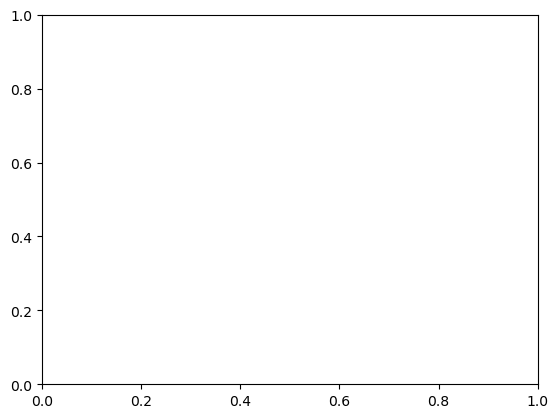

In [ ]:
invals_tijd = invals.copy()
invals_tijd = np.transpose(invals_tijd)
invals_tijd[3] -= 10
invals_tijd = np.transpose(invals_tijd)
amp_x, amp_x_error, invals_x = fix_data(afstanden, T, V, V_fout, invals_tijd, detailed_logs=True, fit_x_vals=False)

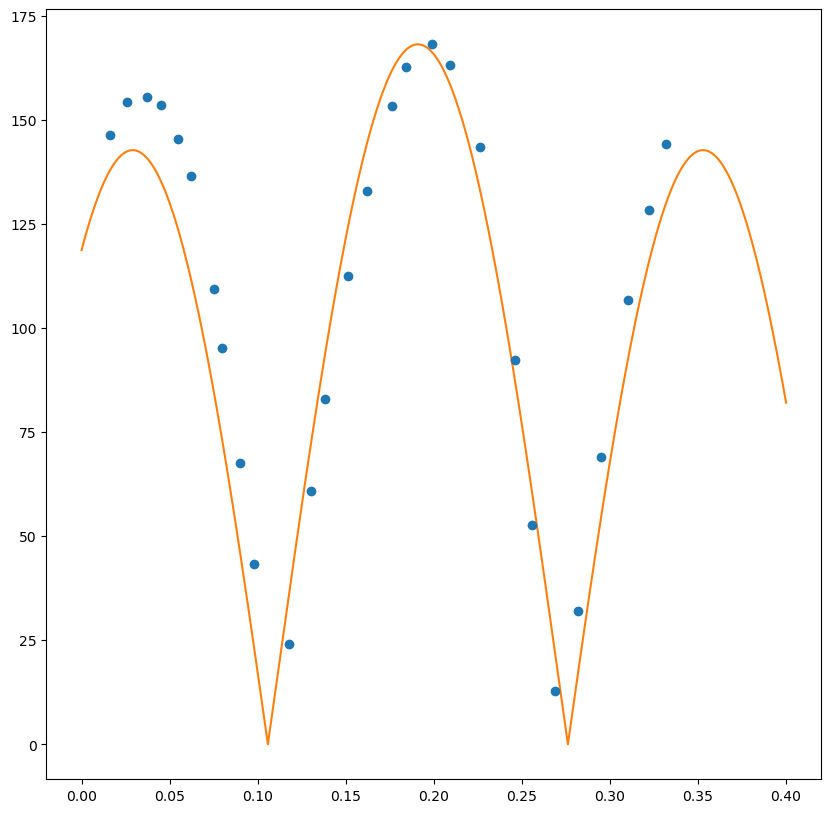

In [17]:
invals_x
fig,ax = plt.subplots(1,1, figsize=(10,10))
ax.errorbar(afstanden, amp_x, yerr=amp_x_error, fmt = "o")
afst = np.linspace(0,0.4, 10000)
ax.plot(afst, np.abs(invals_x[1]*np.sin(invals_x[0]*afst + invals_x[2]) + invals_x[3]))
plt.show()

Raw output
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 2972389623.8646564
             x: [ 3.508e+01  1.393e+02 -3.021e+00 -2.753e-01]
           nit: 223
          nfev: 388
 final_simplex: (array([[ 3.508e+01,  1.393e+02, -3.021e+00, -2.753e-01],
                       [ 3.508e+01,  1.393e+02, -3.021e+00, -2.753e-01],
                       ...,
                       [ 3.508e+01,  1.393e+02, -3.021e+00, -2.753e-01],
                       [ 3.508e+01,  1.393e+02, -3.021e+00, -2.753e-01]]), array([ 2.972e+09,  2.972e+09,  2.972e+09,  2.972e+09,
                        2.972e+09]))
[[8.735200791254274, 35.079588517174514], [139.34562043510192, 139.35020819534117], [-3.020616166750526, -3.0206161667398286], [-0.27533292794657915, -0.27530713213914576]]
k heeft als waarde: 35.079 + 9.3799e-05 - 26.344 met 68% betrouwbaarheidsinterval: [8.7352, 35.08] 
p_0 heeft als waarde: 139.35 + 0.0022971 - 0.0022907 met 68% betrouwbaa

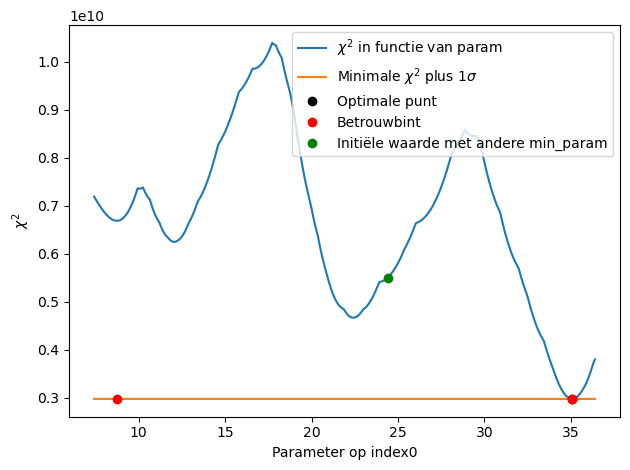

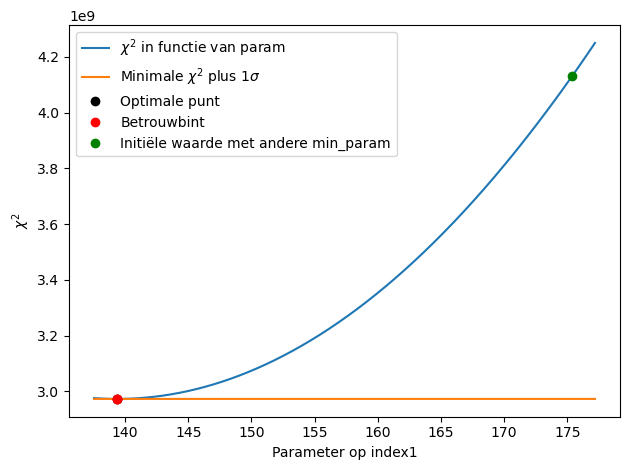

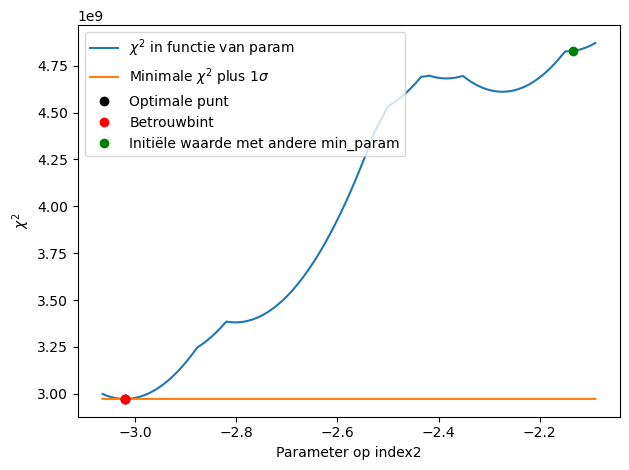

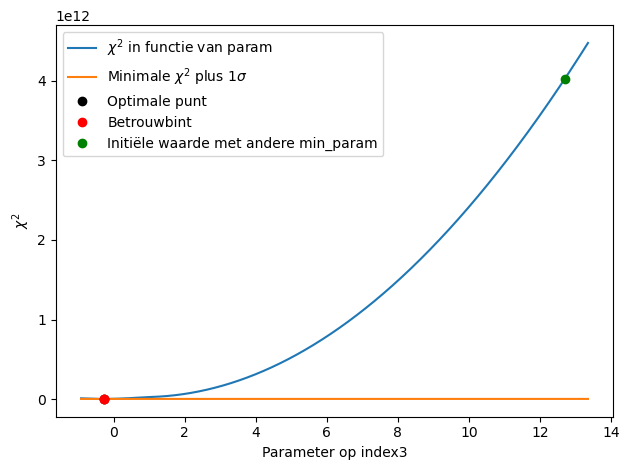

De p-waarde voor de hypothese test dat het model zinvol is, wordt gegeven door: 0
De gereduceerde chi^2 waarde is: 1.2385e+08
test123
test123
test123
test123
test123


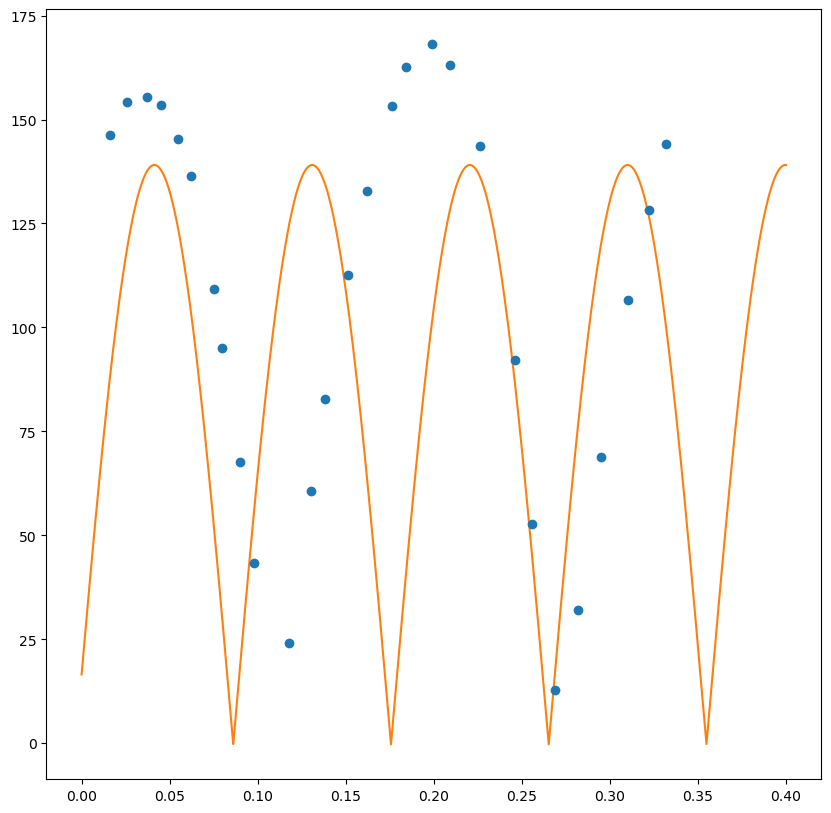

In [ ]:
invals_x_alt = invals_x.copy()
invals_x_alt[1] = invals_x_alt[1] + 20
invals_x_alt[0] = invals_x_alt[0] + 5
K, P_0, PHI, c = fit_naar_x(afstanden, amp_x, amp_x_error, invals_x_alt, detailed_logs=True)
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.errorbar(afstanden, amp_x, yerr=amp_x_error, fmt = "o")
druk_fit = P_0.get_val()*abs(np.sin(K.get_val()*afst+PHI.get_val())) + c[0]
ax.plot(afst, druk_fit)
plt.show()